In [41]:
import os
import pickle 
import pandas as pd
import numpy as np
import jieba
import re
import matplotlib.pyplot as plt 
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

In [32]:
NTUSD=pd.read_csv('NTUSD_Sentiment_Scores.csv')
OF=pd.read_csv('Opnion_Finder_Sentiment_Scores.csv')

# Function used

In [55]:
def plot_dense_line_chart(x, y, title): 
    # Risize the figure (optional)    
    plt.figure(figsize=(20,8))

    # Plot the x and y values on the graph
    plt.plot(x, y)

    # Here you specify the ticks you want to display
    # You can also specify rotation for the tick labels in degrees or with keywords.
    plt.xticks(x[::300],  rotation=45)

    # Add margins (padding) so that markers don't get clipped by the axes
    plt.margins(0.2)

    # Display the graph
    plt.title(title)
    plt.show()
    
def outlier_mapping(x, mean, std):
    return int((x-mean)/std)

# Normalization & Plot

In [17]:
from sklearn.preprocessing import MinMaxScaler
NTUSD_scaler = MinMaxScaler()
OF_scaler = MinMaxScaler()

In [23]:
NTUSD['Scaled'] = NTUSD_scaler.fit_transform(NTUSD[['score']])
OF['Scaled'] = OF_scaler.fit_transform(OF[['OF_Transform']])

In [27]:
NTUSD['Scaled'][:100]

0     0.637398
1     0.673853
2     0.670740
3     0.671007
4     0.683324
        ...   
95    0.588169
96    0.544928
97    0.587810
98    0.667732
99    0.568948
Name: Scaled, Length: 100, dtype: float64

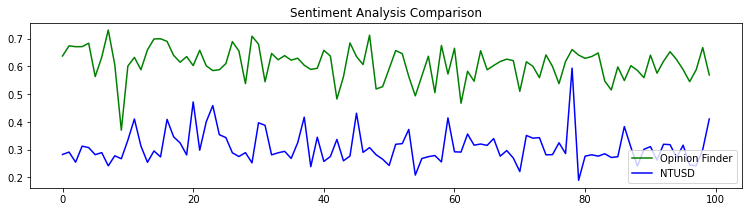

In [28]:
# Placing the plots in the plane
fig = plt.gcf()
fig.set_size_inches(10.5, 5.5)
n = 2
plot1 = plt.subplot2grid((n, n), (1, 0), colspan=3) 

# Graph details
plot1.plot(NTUSD['Scaled'][:100], c='g', label='Opinion Finder')
plot1.plot(OF['Scaled'][:100], c='b', label='NTUSD')
plot1.legend(loc=4)
plot1.set_title('Sentiment Analysis Comparison')

# Packing all the plots and displaying them
plt.tight_layout()
plt.show()

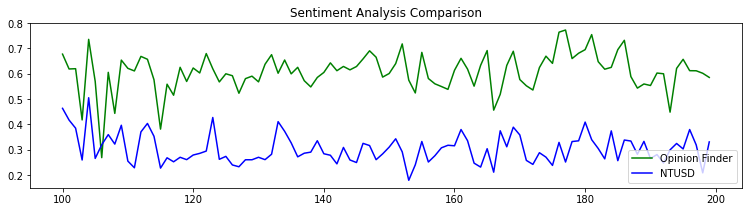

In [29]:
# Placing the plots in the plane
fig = plt.gcf()
fig.set_size_inches(10.5, 5.5)
n = 2
plot1 = plt.subplot2grid((n, n), (1, 0), colspan=3) 

# Graph details
plot1.plot(NTUSD['Scaled'][100:200], c='g', label='Opinion Finder')
plot1.plot(OF['Scaled'][100:200], c='b', label='NTUSD')
plot1.legend(loc=4)
plot1.set_title('Sentiment Analysis Comparison')

# Packing all the plots and displaying them
plt.tight_layout()
plt.show()

# 特異值

In [39]:
combine_df = NTUSD.merge(OF, on='date', how='inner')
combine_df.rename(columns = {'score':'NTUSD_Score', 'OF_Transform':'Opinion_Finder_Score', 'date':'Date'}, inplace = True)
combine_df = combine_df.set_index('Date')
combine_df.head()

,NTUSD_Score,Opinion_Finder_Score
Date,,
2008-08-11,0.511969,-0.405229
2008-08-12,0.554899,-0.396117
2008-08-13,0.551233,-0.434802
2008-08-14,0.551547,-0.373219
2008-08-15,0.566052,-0.378917


In [44]:
NTUSD_mean = np.mean(combine_df['NTUSD_Score'])
NTUSD_std = np.std(combine_df['NTUSD_Score'])
OF_mean = np.mean(combine_df['Opinion_Finder_Score'])
OF_std = np.std(combine_df['Opinion_Finder_Score'])

In [60]:
combine_df['NTUSD_num_of_std'] = combine_df['NTUSD_Score'].apply(lambda x: outlier_mapping(x, NTUSD_mean, NTUSD_std))
combine_df['OF_num_of_std'] = combine_df['Opinion_Finder_Score'].apply(lambda x: outlier_mapping(x, OF_mean, OF_std))

# Extreme Case (std >3)

In [66]:
NTUSD_extreme_high = []
OF_extreme_high = []
NTUSD_extreme_low = []
OF_extreme_low = []
sz = len(combine_df['NTUSD_Score'])

for i in range(sz): 
    # NTUSD
    if(combine_df['NTUSD_num_of_std'][i]>=3):
        NTUSD_extreme_high.append(combine_df.index[i])
    elif(combine_df['NTUSD_num_of_std'][i]<=-3):
        NTUSD_extreme_low.append(combine_df.index[i])
    # Opinion Finder
    if(combine_df['OF_num_of_std'][i]>=3):
        OF_extreme_high.append(combine_df.index[i])
    elif(combine_df['OF_num_of_std'][i]<=-3):
        OF_extreme_low.append(combine_df.index[i])

In [70]:
print(f"Length of NTUSD high: {len(NTUSD_extreme_high)}")
print(f"Length of NTUSD low: {len(NTUSD_extreme_low)}")
print(f"Length of OF high: {len(OF_extreme_high)}")
print(f"Length of OF low: {len(OF_extreme_low)}")

Length of NTUSD high: 19
Length of NTUSD low: 55
Length of OF high: 77
Length of OF low: 3


In [76]:
count=0
for date in NTUSD_extreme_high:
    if date in OF_extreme_high: 
        count +=1
print(f"Extreme high match: {count}")
count=0
for date in NTUSD_extreme_low:
    if date in OF_extreme_low: 
        count +=1
print(f"Extreme low match: {count}")

Extreme high match: 0
Extreme low match: 0


# 中高等級

In [77]:
NTUSD_moderate_high = []
OF_moderate_high = []
NTUSD_moderate_low = []
OF_moderate_low = []
sz = len(combine_df['NTUSD_Score'])

for i in range(sz): 
    # NTUSD
    if(1<=combine_df['NTUSD_num_of_std'][i]<=2):
        NTUSD_moderate_high.append(combine_df.index[i])
    elif(-2<=combine_df['NTUSD_num_of_std'][i]<=-1):
        NTUSD_moderate_low.append(combine_df.index[i])
    # Opinion Finder
    if(1<=combine_df['OF_num_of_std'][i]<=2):
        OF_moderate_high.append(combine_df.index[i])
    elif(-2<=combine_df['OF_num_of_std'][i]<=-1):
        OF_moderate_low.append(combine_df.index[i])

In [79]:
print(f"Length of NTUSD high: {len(NTUSD_moderate_high)}")
print(f"Length of NTUSD low: {len(OF_moderate_high)}")
print(f"Length of OF high: {len(NTUSD_moderate_low)}")
print(f"Length of OF low: {len(OF_moderate_low)}")

Length of NTUSD high: 521
Length of NTUSD low: 528
Length of OF high: 466
Length of OF low: 421


In [81]:
count=0
for date in OF_moderate_high:
    if date in NTUSD_moderate_high: 
        count +=1
print(f"Moderate high match: {count}/{len(OF_moderate_high)}")
count=0
for date in OF_moderate_low:
    if date in NTUSD_moderate_low: 
        count +=1
print(f"Moderate low match: {count}/{len(OF_moderate_low)}")

Moderate high match: 52/528
Moderate low match: 66/421


# Grading criteria

In [82]:
name = "C:/Users/USER/Desktop/Prof_Hsieh_Project/about_emotion/Chinese_derivative/NTUSD_Fin_sentiment.json"
df_score = pd.read_json(name, encoding="utf-8")
# df_score = df[['token', 'market_sentiment']]
df_score

,token,market_sentiment
0,筆記,1.081211
1,機械手,1.221692
2,吸,-1.507409
3,車庫,1.069689
4,艾滋病,0.922132
...,...,...
8441,☕,1.141662
8442,😀,-0.644559
8443,👍,1.100400
8444,👆,1.059200


In [83]:
df_score['market_sentiment'].describe()

count    8446.000000
mean        0.570526
std         0.950257
min        -4.418490
25%         0.325545
50%         1.010188
75%         1.128583
max         1.221692
Name: market_sentiment, dtype: float64